In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from astropy.io import ascii, fits

plt.style.use('HCH_plotstyle')


from tqdm import tqdm_notebook as tqdm

/Users/Hwang/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  # This is added back by InteractiveShellApp.init_path()


In [3]:
import sys

if '../' not in sys.path:
    sys.path.append('../')

import binary_sampling


import importlib
importlib.reload(binary_sampling)
    
from binary_sampling import *


In [49]:
e_list = np.concatenate(
    [
        np.arange(0., 1.0, 0.1),
        np.array([0.99, 0.999, 0.9999, 0.99999])
    ]
)
N_phase = 1000

M_list = 2 * np.pi * np.linspace(0., 1.0001, N_phase+1, endpoint=True)


f_list_list = []

for e in e_list:
    
    f_list = random_true_anomaly(e, N_phase, u_precision = 360. * np.pi / 180. / N_phase / 50., equal_spaced_M=True, init_by_grid_data=False)
    
    f_list = np.concatenate([f_list, [2*np.pi]]) #add the 2*pi endpoint
    
    f_list_list.append(f_list)
    
f_list_list = np.array(f_list_list)

In [50]:
M = 6.25239456

u = 6.25239456

ee = 0.99999

u_precision = 360. * np.pi / 180. / N_phase / 50.

correction = (M - u + ee * sin(u)) / (1. - ee * cos(u))


correction = correction * 0.01

print(correction)
while np.abs(correction) > u_precision:
    
    print(u)
    
    u = u + correction
    correction = (M - u + ee * sin(u)) / (1. - ee * cos(u))
    
    

-0.6360749598019604
6.25239456
5.6163196001980396
5.698258679732674
5.710307541436155


In [6]:
(M - u + ee * sin(u))

1.686764938835239e-08

In [7]:
(1. - ee * cos(u))

0.15952863811970885

In [8]:
(M - u + ee * sin(u)) / (1. - ee * cos(u))

1.0573430317693215e-07

In [10]:
print('Make sure that there is no problematic data:')
for i in range(len(e_list)):
    
    f_list = f_list_list[i]
    
    print('Number of NaN: %d' %(np.sum(np.isnan(f_list))))
    
    f_diff = (
        (f_list[1:] - f_list[0:-1])
    )
    print('e=%.5f' %(e_list[i]))
    print('Number of solution crossing: %d' %(np.sum(f_diff<0.)))

Make sure that there is no problematic data:
Number of NaN: 0
e=0.00000
Number of solution crossing: 0
Number of NaN: 0
e=0.10000
Number of solution crossing: 0
Number of NaN: 0
e=0.20000
Number of solution crossing: 0
Number of NaN: 0
e=0.30000
Number of solution crossing: 0
Number of NaN: 0
e=0.40000
Number of solution crossing: 0
Number of NaN: 0
e=0.50000
Number of solution crossing: 0
Number of NaN: 0
e=0.60000
Number of solution crossing: 0
Number of NaN: 0
e=0.70000
Number of solution crossing: 0
Number of NaN: 0
e=0.80000
Number of solution crossing: 0
Number of NaN: 0
e=0.90000
Number of solution crossing: 0
Number of NaN: 0
e=0.99000
Number of solution crossing: 0
Number of NaN: 0
e=0.99900
Number of solution crossing: 0
Number of NaN: 0
e=0.99990
Number of solution crossing: 0
Number of NaN: 0
e=0.99999
Number of solution crossing: 0


In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


rainbow = cm.get_cmap('rainbow', 12)

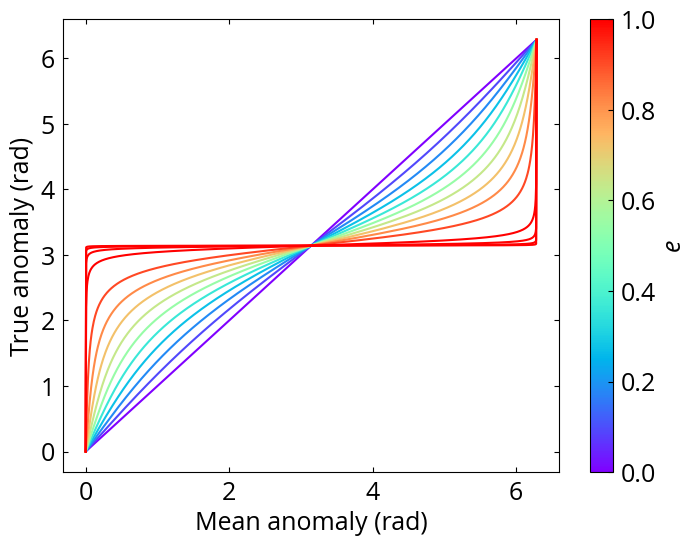

In [13]:
for i in range(len(e_list)):

    plt.plot(
        M_list,
        f_list_list[i],
        label='e=%f' %(e_list[i]),
        c=rainbow(e_list[i])
    )

plt.scatter(
    [],[], vmin=0., vmax=1., cmap='rainbow'
)
plt.colorbar(label=r'$e$')
plt.xlabel('Mean anomaly (rad)')
plt.ylabel('True anomaly (rad)')

plt.show()

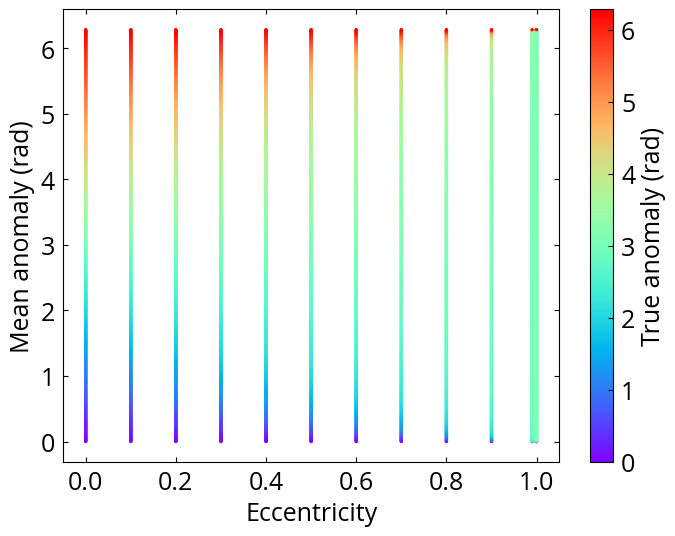

In [14]:
for i in range(len(e_list)):

    plt.scatter(
        [e_list[i]] * len(M_list),
        M_list,
        c=f_list_list[i],
        vmin=0., vmax=2*np.pi,
        s=2
    )


plt.colorbar(label=r'True anomaly (rad)')
plt.xlabel('Eccentricity')
plt.ylabel('Mean anomaly (rad)')

plt.show()

In [15]:
from scipy import interpolate
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

#decided to use griddata instead of interp2d, because interp2d has (sometimes annoying) internal sorting

In [16]:
#add last array at e=1 so that the interpolation function return the e=e_max result for e>e_max
e_list_con = np.concatenate([e_list, [1.]]) 
f_list_list_con = np.concatenate([f_list_list, [f_list_list[-1]]])


In [18]:
xv, yv = np.meshgrid(e_list_con, M_list, indexing='ij')

xy_flatten = np.array(list(zip(xv.flatten(), yv.flatten())))

In [19]:
griddata(xy_flatten, 
         f_list_list_con.flatten(), ([0.5], [1.]), method='linear')

array([2.0307112])

In [20]:
griddata(xy_flatten, 
         f_list_list_con.flatten(), ([0.5, 0.5, 0.8, 0.8], [0., 1., 0.1, 2.5]), method='linear')

array([0.        , 2.0307112 , 1.18750378, 3.02042618])

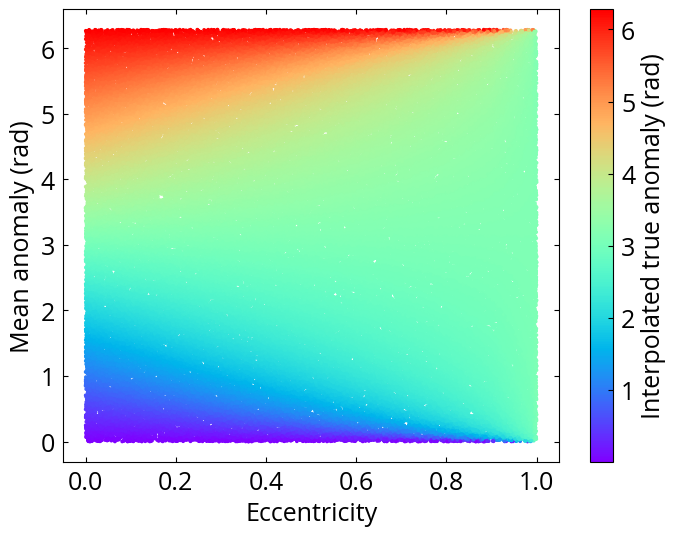

In [22]:
N_random = 100000

e_random = np.random.random(size=N_random)
M_random = np.random.random(size=N_random) * 2. * np.pi

plt.scatter(
    e_random,
    M_random,
    c= griddata(xy_flatten, 
         f_list_list_con.flatten(), (e_random, M_random), method='linear'),
    s=3
)

plt.xlabel('Eccentricity')
plt.ylabel('Mean anomaly (rad)')
plt.colorbar(label='Interpolated true anomaly (rad)')

plt.show()

Interpolated results (black dashed lines) lie on top of the data (interpolation works correctly)


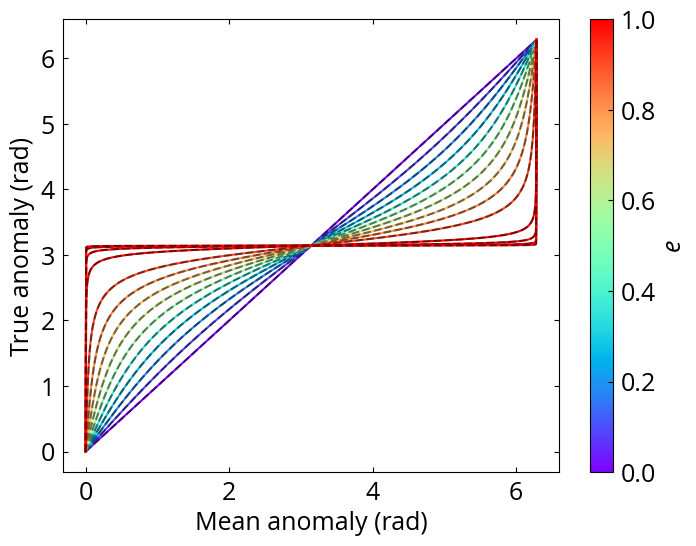

In [25]:
print('Interpolated results (black dashed lines) lie on top of the data (interpolation works correctly)')

for i in range(len(e_list)):

    plt.plot(
        M_list,
        f_list_list[i],
        label='e=%f' %(e_list[i]),
        c=rainbow(e_list[i])
    )
    
    plt.plot(
        M_list,
        griddata(xy_flatten, 
         f_list_list_con.flatten(), ([e_list[i]]*len(M_list), M_list), method='linear'),
        c='k', ls='--', alpha=0.5
    )

plt.scatter(
    [],[], vmin=0., vmax=1., cmap='rainbow'
)
plt.colorbar(label=r'$e$')
plt.xlabel('Mean anomaly (rad)')
plt.ylabel('True anomaly (rad)')

plt.show()

In [36]:
np.save('mean_to_true_anomaly_grid', [e_list, M_list, f_list_list])

/Users/Hwang/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


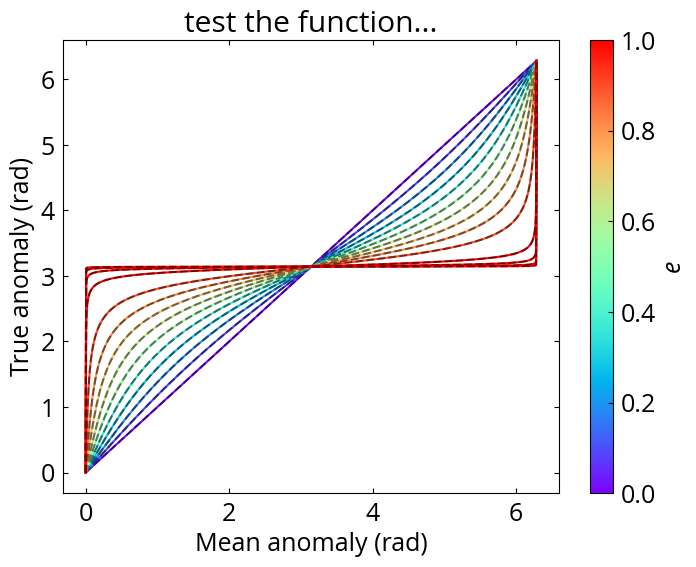

In [47]:
plt.title('test the function...')

for i in range(len(e_list)):

    plt.plot(
        M_list,
        f_list_list[i],
        label='e=%f' %(e_list[i]),
        c=rainbow(e_list[i])
    )
    
    plt.plot(
        M_list,
        mean_to_true_anomaly_from_grid([e_list[i]]*len(M_list), M_list),
        c='k', ls='--', alpha=0.5
    )

plt.scatter(
    [],[], vmin=0., vmax=1., cmap='rainbow'
)
plt.colorbar(label=r'$e$')
plt.xlabel('Mean anomaly (rad)')
plt.ylabel('True anomaly (rad)')

plt.show()